# LiFS

## Imports

In [1]:
import sys
import os

PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
INDOOR_COMPETITION_20_DIR = os.path.join(
    PROJECT_HOME, "code", "indoor-location-competition-20"
)
print("The library is located at", INDOOR_COMPETITION_20_DIR)
sys.path.append(INDOOR_COMPETITION_20_DIR)

CODE_DIR = os.path.join(PROJECT_HOME, "code")
print(f"The code is located in {CODE_DIR}")
sys.path.append(CODE_DIR)

The library is located at ./../../code/indoor-location-competition-20
The code is located in ./../../code


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from io_f import read_data_file
from pathlib import Path
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall
from collections import defaultdict
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS

from py_indoor_loc.utils import DataListingUtil
from py_indoor_loc.sensors import estimate_acceleration_heading
from py_indoor_loc.extract.wifi_fingerprint import extract_bssid_set
from py_indoor_loc.extract.wifi_fingerprint import create_fingerprint_vector

In [3]:
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries, scale
from py_indoor_loc.zee import create_search_grid, SearchGrid
from shapely import ops as shapely_ops
from shapely import vectorized as shapely_vectorized
from shapely.geometry import LineString

In [4]:
%matplotlib inline

In [10]:
import networkx as nx

In [194]:
import seaborn as sns

## Read Train/Test Assignment

In [5]:
data_dir = Path("../../data/train/")

train_test_assignment = pd.read_csv("../../data/output/20230903_train_test_assignment.csv")
train_test_assignment["site_id"] = train_test_assignment["site_id"].astype("category")
train_test_assignment["floor_id"] = train_test_assignment["floor_id"].astype("category")
train_test_assignment["dataset"] = train_test_assignment["dataset"].astype("category")

experiment_setup = pd.read_csv("../../data/output/20230903_semi_supervision_setup.csv", index_col=0)

for col in ["site_id", "floor_id", "dataset"]:
  experiment_setup[col] = experiment_setup[col].astype("category")

data_listing_util = DataListingUtil(train_test_assignment, experiment_setup, data_dir=data_dir)

site_floors = experiment_setup[["site_id", "floor_id"]].drop_duplicates().values

In [6]:
site_id, floor_id = site_floors[1]

In [7]:
train_files = data_listing_util.list_train_files(site_id, floor_id)

## LiFS: Stress-free Floor Plan

In [8]:
metadata_dir = Path("../../data/metadata/")

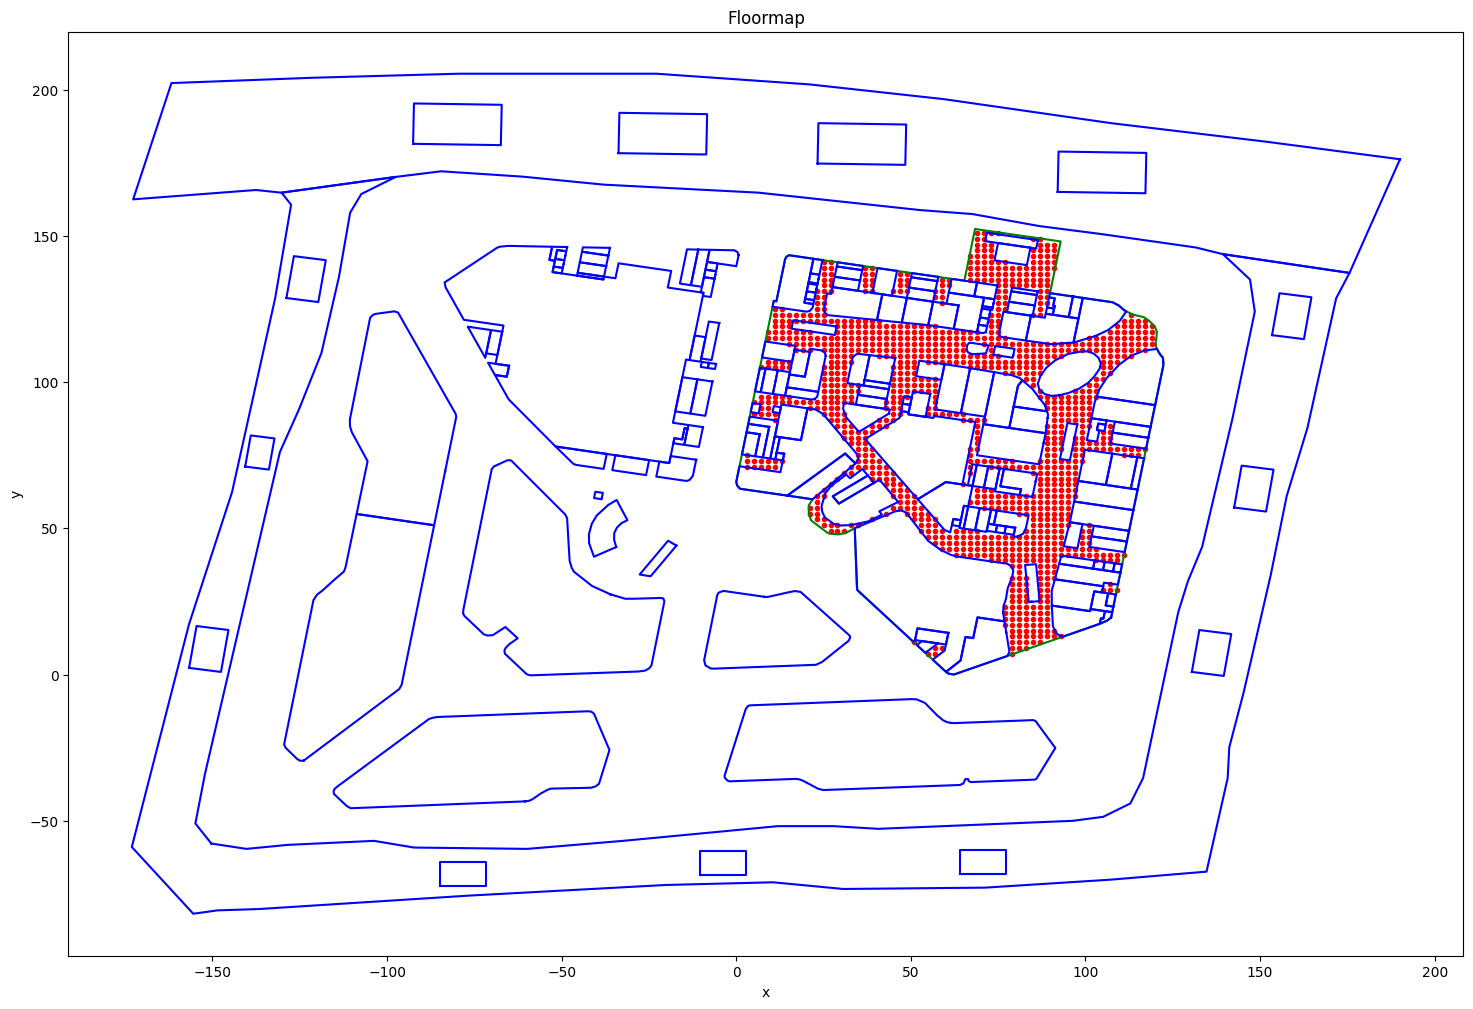

In [9]:
floor_info, floor_map = read_floor_data(str(metadata_dir / site_id / floor_id))

transform_func = lambda x: x
(
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

search_grid = create_search_grid(floor_polygons,
                                 store_polygons,
                                 width_meter,
                                 height_meter,
                                 grid_resolution=2.0,
                                 tol=0.001)


fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.buffer(0.001).exterior.xy
  ax.plot(x, y, color="green", label="floor")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue", label="store")


ax.scatter(search_grid.grid_points[:, 0], search_grid.grid_points[:, 1], marker=".", color="red", label="sample")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

plt.ticklabel_format(useOffset=False)
plt.show()

### Construction of stress-free floor plan

* Sample the area of interests with a mesh of grids in a floor plan.
* Calculating the distance between all pairs of locations to obtain the distance matrix `D = [dij]`.
* `dij` is the walking distance between point `i` and point `j`

In [11]:
g = nx.Graph()
n = search_grid.n_points
pts = search_grid.grid_points

for i in range(n):
  for j in range(i + 1, n):
    if np.abs(pts[j] - pts[i]).sum() == search_grid.grid_resolution:
      g.add_edge(i, j, d=search_grid.grid_resolution)


In [12]:
cc = list(nx.connected_components(g))

In [13]:
cc.sort(key=lambda c: len(c), reverse=True)

In [14]:
[len(e) for e in cc]

[1071, 16, 12, 10, 9, 9, 9, 4, 4, 2]

In [15]:
keep_points = np.array(list(cc[0]))

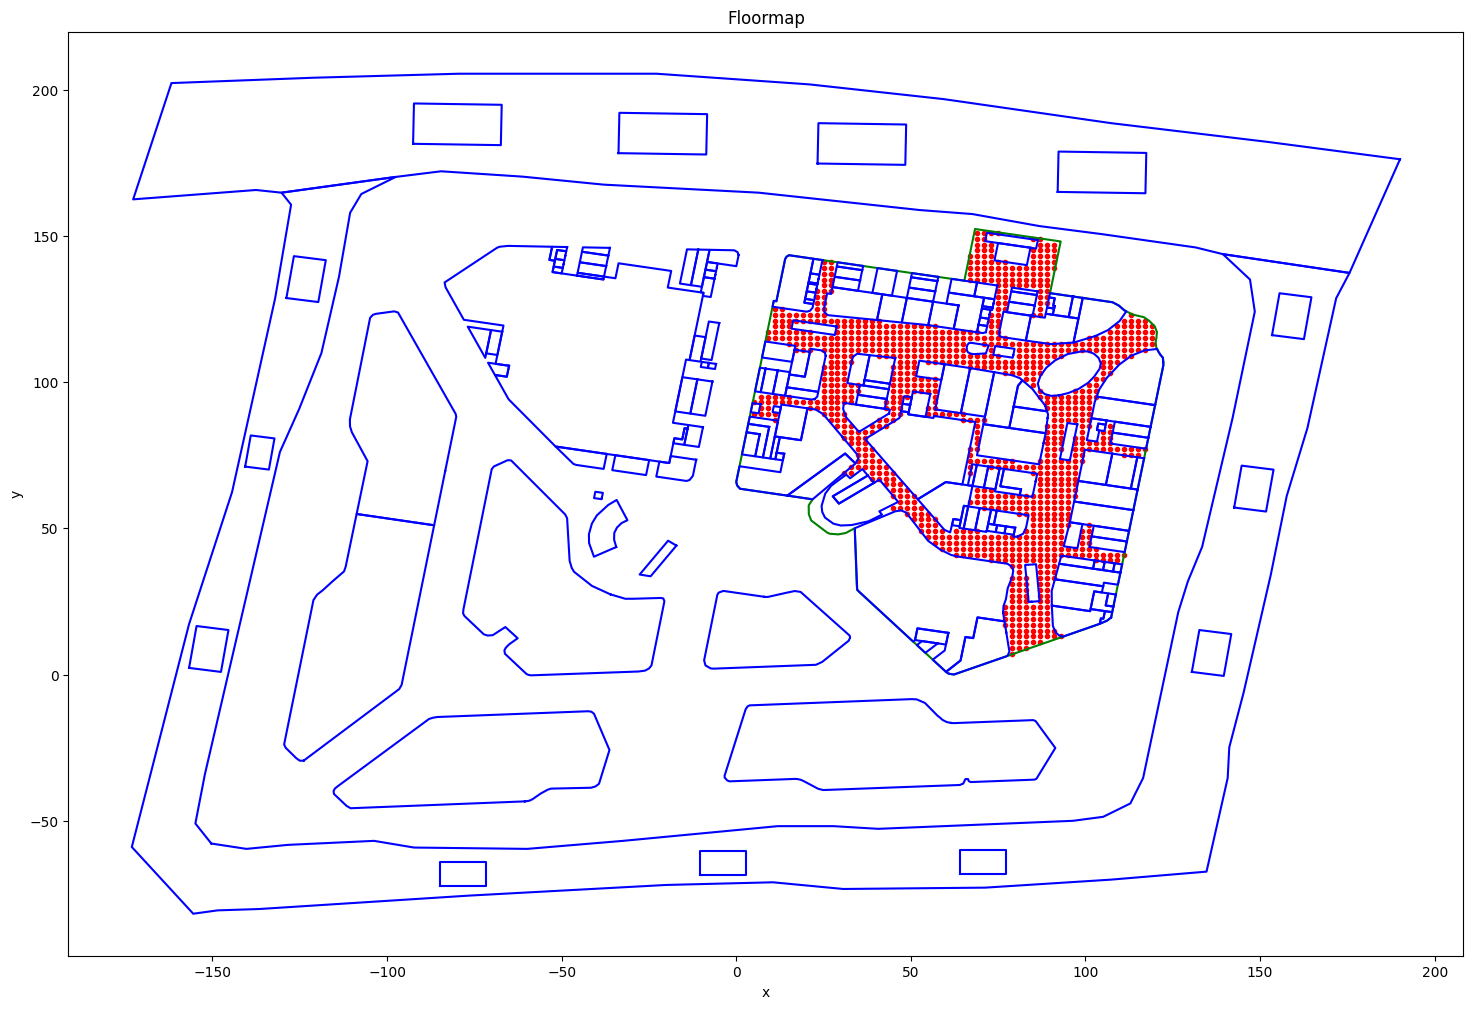

In [16]:
floor_info, floor_map = read_floor_data(str(metadata_dir / site_id / floor_id))

transform_func = lambda x: x
(
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)


fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.buffer(0.001).exterior.xy
  ax.plot(x, y, color="green", label="floor")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue", label="store")


ax.scatter(search_grid.grid_points[keep_points, 0], search_grid.grid_points[keep_points, 1], marker=".", color="red", label="sample")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

plt.ticklabel_format(useOffset=False)
plt.show()

In [19]:
distances = nx.floyd_warshall_numpy(g.subgraph(cc[0]))

In [20]:
mds = MDS(n_components=2, normalized_stress='auto', dissimilarity="precomputed")
floor_mds = mds.fit_transform(distances)

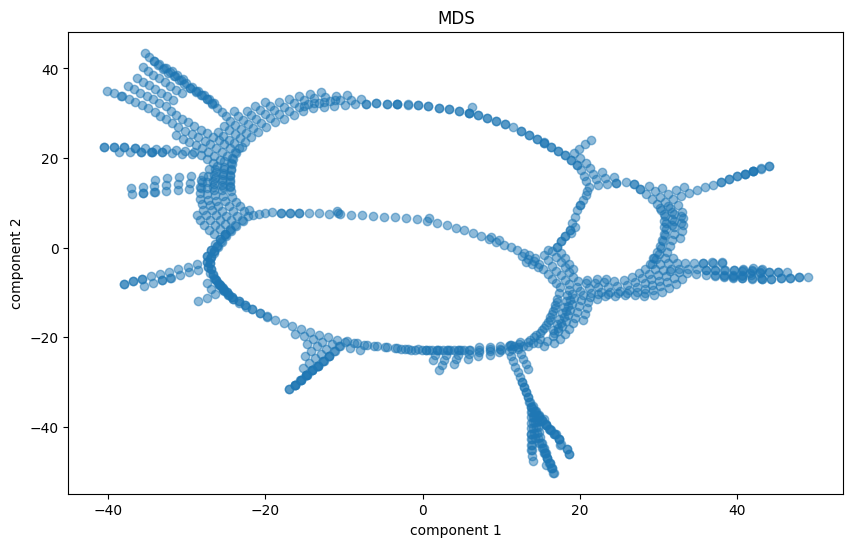

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.scatter(floor_mds[:, 0], floor_mds[:, 1], marker="o", alpha=0.5)
ax.set_xlabel("component 1")
ax.set_ylabel("component 2")
ax.set_title("MDS")

plt.show()

## LiFS: Fingerprint Space

### Step Counter

* The paper used a local variance threshold method to detect the number of steps. The method is based on filtering the magnitude of acceleration followed by applying a threshold on the variance of acceleration over a sliding window.

In [338]:
def compute_mean(acce: np.ndarray, window_size: int = 15) -> np.ndarray:
  n = len(acce)
  w_mean = np.zeros(n, dtype=np.float32)
  for i in range(n):
    start_idx = max(0, i - window_size)
    end_idx = min(n, i + window_size + 1)
    w_mean[i] = np.mean(acce[start_idx:end_idx])
  return w_mean

In [22]:
def compute_local_acc_variance(acce: np.ndarray, window_size: int = 15):
  """
  Compute the local acceleration variance to highlight the foot activity and to remove gravity.
  """
  n = len(acce)
  variance = np.zeros_like(acce, dtype=np.float32)
  for i in range(n):
    start_idx = max(0, i - window_size)
    end_idx = min(n, i + window_size + 1)
    m = np.mean(acce[start_idx:end_idx])
    variance[i] = np.mean(np.square(acce[start_idx:end_idx] - m))
  
  return np.sqrt(variance)


In [23]:
def compute_step_positions(acce_var: np.ndarray, 
                           swing_threshold: float = 2, 
                           stance_threshold: float = 1, 
                           window_size: int = 15):
  n = len(acce_var)
  steps = np.array([False] * n)
  swing = (acce_var > swing_threshold) * swing_threshold
  stance = (~(acce_var < stance_threshold)) * stance_threshold

  for i in range(1, n):
    if (swing[i - 1] < swing[i]) and np.max(stance[i:min(i + window_size, n)]) == stance_threshold:
      steps[i] = True
  
  return steps, swing, stance

In [24]:
path_datas = read_data_file(train_files[0])
acce, _ = estimate_acceleration_heading(path_datas.acce, path_datas.magn)
acce_magnitudes = np.linalg.norm(acce, axis=1)

acce_mean = compute_mean(acce_magnitudes, window_size=5)
acce_var  = compute_local_acc_variance(acce_magnitudes, window_size=5)
steps, swing, stance = compute_step_positions(acce_var, swing_threshold=1., stance_threshold=0.5, window_size=5)

NameError: name 'compute_mean' is not defined

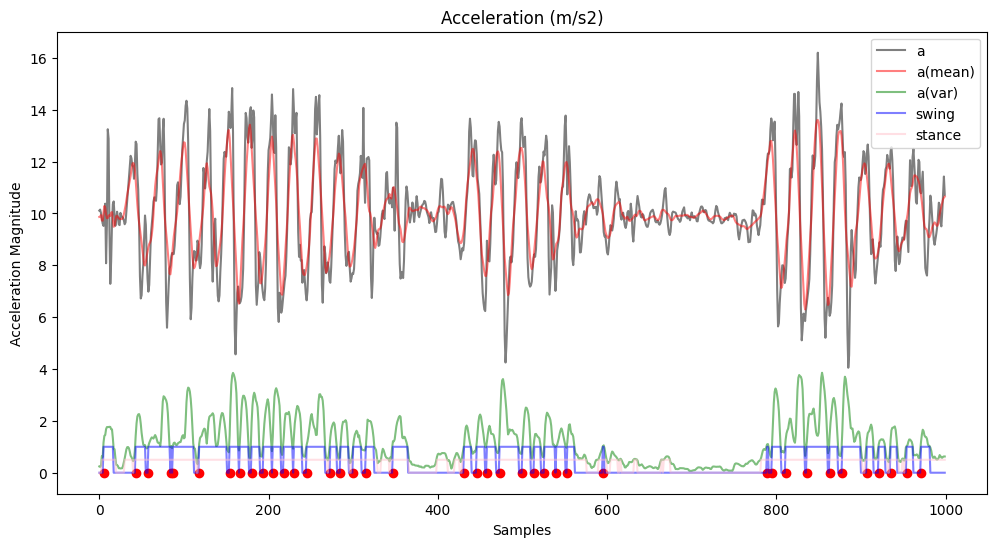

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

n_samples = 1000
ax.plot(acce_magnitudes[:n_samples], alpha=0.5, label="a", color="black")
ax.plot(acce_mean[:n_samples], alpha=0.5, label="a(mean)", color="red")
ax.plot(acce_var[:n_samples], alpha=0.5, label="a(var)", color="green")
ax.plot(swing[:n_samples], alpha=0.5, label="swing", color="blue")
ax.plot(stance[:n_samples], alpha=0.5, label="stance", color="pink")

for i in range(n_samples):
  if steps[i]:
    ax.scatter(i, 0, marker="o", color="red")

ax.set_title("Acceleration (m/s2)")
ax.set_xlabel("Samples")
ax.set_ylabel("Acceleration Magnitude")
ax.legend()

plt.show()

### Distance Between Two Fingerprints in a Walk

In [25]:
def extract_wifi_df(wifi: np.ndarray, time_shift_tol_ms: int = 2000, verbose=False) -> pd.DataFrame:
  """
  Wifi Fingerprint data extraction and cleaning.
  """
  wifi_schema = {
    "sys_ts": "system timestamp",
    "ssid": "the network name",
    "bssid": "the MAC address of the AP",
    "rssi": "RSSI",
    "freq": "Frequency",
    "last_seen_ts": "timestamp in microseconds (since boot) when this result was last seen"
  }
  wifi_df = pd.DataFrame(wifi, columns=list(wifi_schema.keys()))
  wifi_df["bssid"] = wifi_df["bssid"].astype("category")
  wifi_df["ssid"] = wifi_df["ssid"].astype("category")
  wifi_df["sys_ts"] = wifi_df["sys_ts"].astype(np.int64)
  wifi_df["last_seen_ts"] = wifi_df["last_seen_ts"].astype(np.int64)
  wifi_df["rssi"] = wifi_df["rssi"].astype(np.int32)
  wifi_df["freq"] = wifi_df["freq"].astype(np.int32)
  wifi_df = wifi_df[wifi_df["sys_ts"] - wifi_df["last_seen_ts"] <= time_shift_tol_ms].reset_index(drop=True)

  if verbose:
    print(f"Summary stats: n_samples={wifi_df.shape[0]}, n_seen_bssid={wifi_df.bssid.unique().shape[0]}, n_seen_ssid={wifi_df.ssid.unique().shape[0]}")
  
  return wifi_df

* Extract BSSID vector

In [26]:
def extract_wifi_df_list(files, time_shift_tol_ms: int = 2000):
  wifi_df_list = []

  for file in files:
    path_datas = read_data_file(file)
    wifi_df = extract_wifi_df(path_datas.wifi, time_shift_tol_ms)
    wifi_df_list.append(wifi_df)

  return wifi_df_list

In [27]:
wifi_df_list = extract_wifi_df_list(train_files, time_shift_tol_ms=1000)

In [28]:
bssid_set = extract_bssid_set(wifi_df_list, min_times=0)
bssid_vector = np.array(list(bssid_set))

In [29]:
len(bssid_vector)

1995

In [381]:
# TODO: Scale to [0, 1] like in EZ paper

In [380]:
F[F > -999].min()

-93.0

* Extract fingerprints and their distance matrix for each path

In [30]:
def extract_FD(path_datas, bssid_vector, window_size=5, swing_threshold=2, stance_threshold=1, not_seen_ap_rssi=-999, time_shift_tol_ms=1000):

  # Step detection
  acce_ecrs, _ = estimate_acceleration_heading(path_datas.acce, path_datas.magn)
  acce_magnitudes = np.linalg.norm(acce_ecrs, axis=1)
  acce_var  = compute_local_acc_variance(acce_magnitudes, window_size=window_size)
  steps, _, _ = compute_step_positions(acce_var, swing_threshold=swing_threshold, stance_threshold=stance_threshold, window_size=window_size)

  wifi_df = extract_wifi_df(path_datas.wifi, time_shift_tol_ms)

  ft = []
  for sys_ts, group_data in wifi_df.groupby("sys_ts"):
    f = create_fingerprint_vector(group_data, bssid_vector, not_seen_ap_rssi)
    ft.append([sys_ts, f])
  ft.sort(key=lambda v: v[0])

  wifi_t, wifi_f = zip(*ft)
  wifi_t = np.array(wifi_t)
  wifi_f = np.vstack(wifi_f)

  acce_ts = path_datas.acce[:, 0].astype(np.int64)

  # D[i] = distance between wifi F[i] and F[i+1]
  fd = []
  for i in range(len(wifi_t) - 1):
    curr_time, next_time = wifi_t[i], wifi_t[i + 1]
    indices = np.where((acce_ts >= curr_time) & (acce_ts <= next_time))
    start_idx, end_idx = indices[0][0], indices[0][-1]
    n_steps = np.count_nonzero(steps[start_idx:end_idx + 1])
    fd.append(n_steps)
  fd = np.array(fd, dtype=np.int32)

  assert wifi_f.shape[0] == fd.shape[0] + 1

  return wifi_f, fd

* Stacking fingerprints

In [31]:
f_list = []
d_dict = dict()

n = 0

for train_file in tqdm(train_files):
  path_datas = read_data_file(train_file)
  F, D = extract_FD(path_datas, bssid_vector, window_size=5, not_seen_ap_rssi=-100)

  start_idx = n

  for i, d in enumerate(D):
    d_dict[(n + i, n + i + 1)] = d
  
  f_list.append(F)
  n += len(F)

F = np.vstack(f_list)

100%|██████████| 69/69 [00:20<00:00,  3.38it/s]


* Using Floyd-Warshall algorithm to create pairwise distance matrix between fingerprints
* Fingerprint grouping based on dissimilarity

In [108]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [ ]:
def ap_select(F: np.ndarray, bssid_vector: np.ndarray):
  

In [44]:
F_norm = F / 100 
F_mean = np.mean(F_norm, axis=1)
F_norm = F_norm - F_mean.reshape(-1, 1)

In [142]:
def f_dissimilarity(f1, f2):
  return np.abs(f1 - f2).mean()

In [143]:
pw_d = pairwise_distances(F_norm.T, metric=f_dissimilarity)

In [218]:
ap_priority = np.count_nonzero(F.T + 100, axis=1) / F.T.shape[0]

In [165]:
silhouette_scores = []
n_clusters_values = []

for n_clusters in np.arange(2, 200, 1):
  ap_clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric="precomputed",
    linkage="average",
  ).fit(pw_d)

  if ap_clustering.n_clusters_ == 1 or ap_clustering.n_clusters_ == len(pw_d):
    continue

  n_clusters_values.append(n_clusters)
  silhouette_scores.append(silhouette_score(pw_d, labels=ap_clustering.labels_, metric="precomputed"))

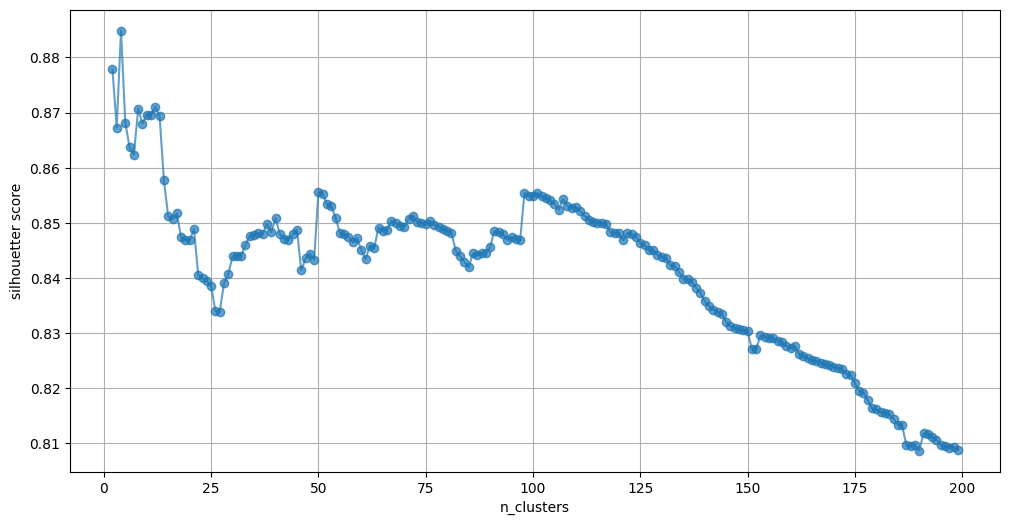

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(n_clusters_values, silhouette_scores, marker="o", alpha=0.7)
ax.set_ylabel("silhouetter score")
ax.set_xlabel("n_clusters")
ax.grid()

plt.show()

In [208]:
ap_clustering = AgglomerativeClustering(
    n_clusters=10,
    metric="precomputed",
    linkage="average",
).fit(pw_d)

In [209]:
pd.Series(ap_clustering.labels_).value_counts()

7    1880
3      38
2      18
1      18
8      12
5       6
0       6
4       6
6       6
9       5
Name: count, dtype: int64

In [217]:
ap_priority.shape

(1251,)

In [219]:
ap_priority[np.where(ap_clustering.labels_ == 3)[0]]

array([0.22305764, 0.12481203, 0.13132832, 0.12531328, 0.10225564,
       0.12581454, 0.09373434, 0.18496241, 0.13433584, 0.18596491,
       0.08220551, 0.14736842, 0.23458647, 0.17042607, 0.11528822,
       0.18295739, 0.21804511, 0.21654135, 0.12330827, 0.09323308,
       0.12531328, 0.22656642, 0.11027569, 0.10025063, 0.12882206,
       0.16992481, 0.11177945, 0.22506266, 0.19197995, 0.08521303,
       0.19699248, 0.20601504, 0.13082707, 0.20300752, 0.13132832,
       0.21553885, 0.08972431, 0.16090226])

In [222]:
bssid_vector[np.where(ap_clustering.labels_ == 3)[0]][np.argmax(ap_priority[np.where(ap_clustering.labels_ == 3)[0]])]

'93dcf9f3ffa932065ec1e7391cfd87afd1ad1374'

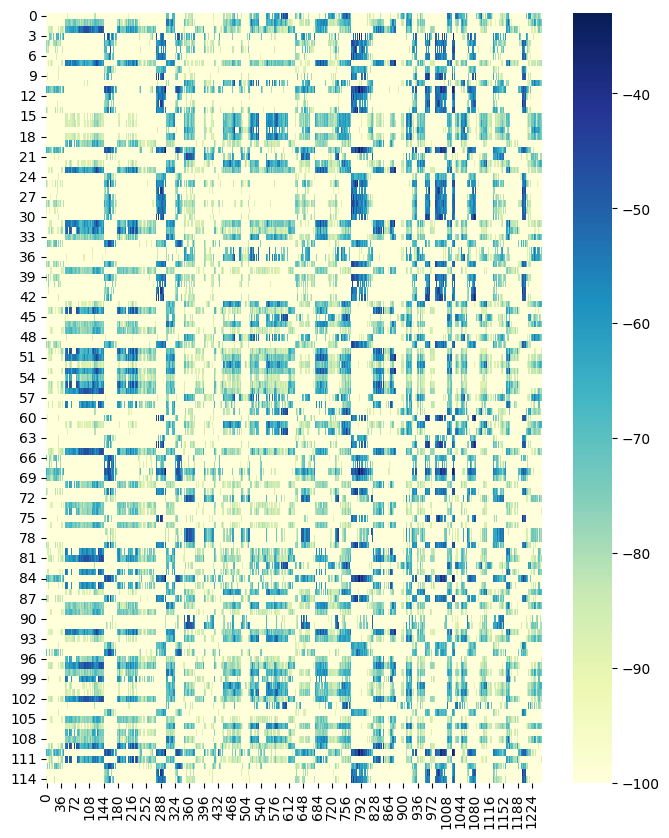

In [210]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

sns.heatmap(F.T[ap_clustering.labels_ != 7, :], cmap="YlGnBu")

plt.show()

In [350]:
scaler = MaxAbsScaler().fit(F)
F_s = scaler.transform(F)

In [351]:
def fingerprint_diff(f1: np.ndarray, f2: np.ndarray) -> float:
  return np.abs(f1 - f2).sum()

In [352]:
def compute_fdist_matrix(d_dict, cluster_labels):
  n_points = len(set(cluster_labels))

  fdist = defaultdict(list)

  for (u, v), n_steps in d_dict.items():
    u_c, v_c = cluster_labels[u], cluster_labels[v]
    if u_c != v_c:
      fdist_key = (min(u_c, v_c), max(u_c, v_c))
      fdist[fdist_key].append(n_steps)
  
  result = np.zeros((n_points, n_points), dtype=np.float32)
  for (u, v), n_steps in fdist.items():
    mean_n_steps = np.mean(n_steps)
    result[u, v] = mean_n_steps
    result[v, u] = mean_n_steps
  
  return result

In [361]:
FD = pairwise_distances(F, metric="l1")

In [367]:
clustering = AgglomerativeClustering(distance_threshold=30,
                                     metric="precomputed",
                                     n_clusters=None,
                                     linkage="average")

_ = clustering.fit(FD)

In [368]:
len(set(clustering.labels_))

1248

In [369]:
fdist_matrix = compute_fdist_matrix(d_dict, cluster_labels=clustering.labels_)

In [370]:
graph = csr_matrix(fdist_matrix)
fingerprint_space_dist_matrix, predecessors = floyd_warshall(csgraph=graph, directed=False, return_predecessors=True)

* Applying MDS on fingerprint space

In [371]:
embedding = MDS(n_components=2, normalized_stress='auto', dissimilarity="precomputed")
fingerprint_mds_2d = embedding.fit_transform(fdist_matrix)

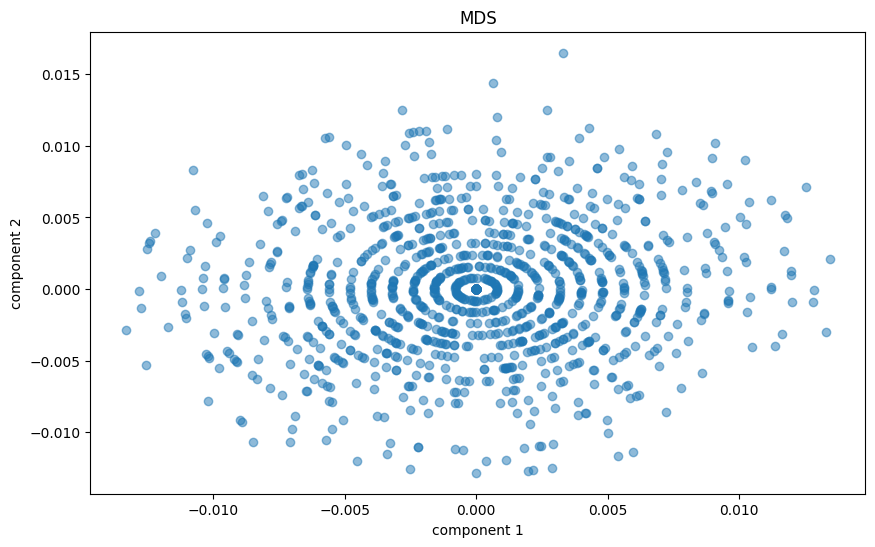

In [372]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.scatter(fingerprint_mds_2d[:, 0], fingerprint_mds_2d[:, 1], marker="o", alpha=0.5)
ax.set_xlabel("component 1")
ax.set_ylabel("component 2")
ax.set_title("MDS")

plt.show()

In [373]:
embedding_3d = MDS(n_components=3, normalized_stress='auto', dissimilarity="precomputed")
fingerprint_mds_3d = embedding_3d.fit_transform(fdist_matrix)

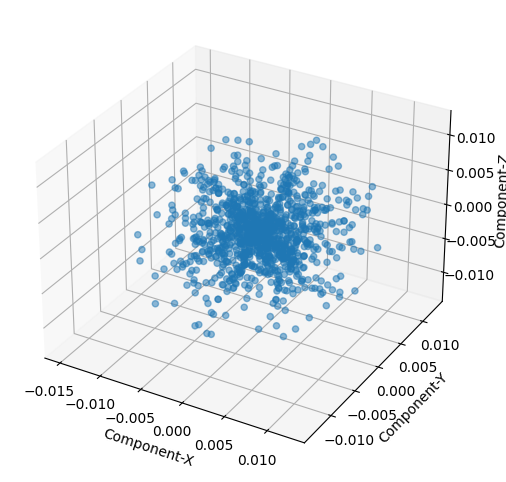

In [374]:
# Create a 3D figure
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Create the 3D surface plot
ax.scatter(fingerprint_mds_3d[:, 0], fingerprint_mds_3d[:, 1], fingerprint_mds_3d[:, 2], marker="o", alpha=0.5)

# Add labels and a colorbar
ax.set_xlabel('Component-X')
ax.set_ylabel('Component-Y')
ax.set_zlabel('Component-Z')

# Show the plot
plt.show()

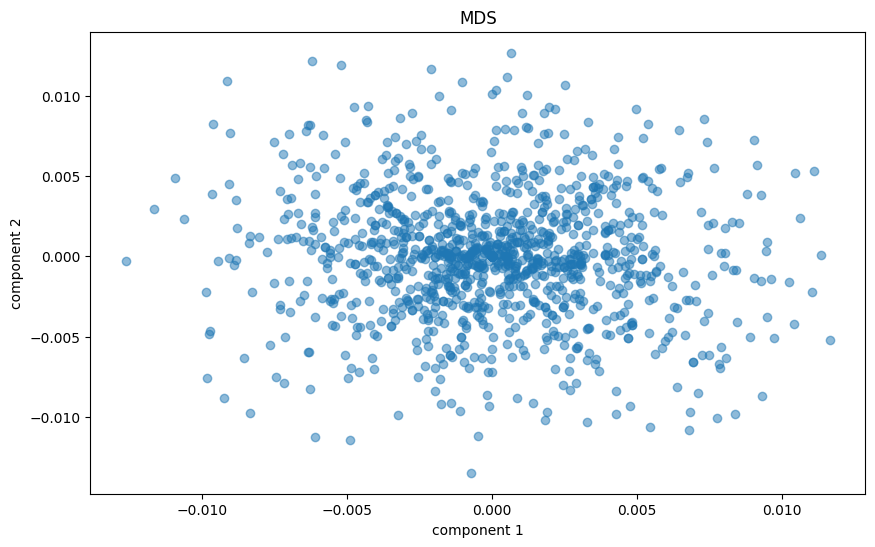

In [376]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.scatter(fingerprint_mds_3d[:, 2], fingerprint_mds_3d[:, 1], marker="o", alpha=0.5)
ax.set_xlabel("component 1")
ax.set_ylabel("component 2")
ax.set_title("MDS")

plt.show()

* Using labeled data to estimate the threshold for agglomerative clustering

In [221]:
base_wifi_fingerprint_data_dir = Path("../../data/wifi_fingerprint_manual/train/")

In [222]:
wifi_fingerprint_files = [base_wifi_fingerprint_data_dir / site_id / floor_id / f"{os.path.basename(p)[:-len('.txt')]}_wifi_fingerprint.csv"
                          for p in train_files]

In [223]:
from py_indoor_loc.extract.wifi_fingerprint import extract_fingerprint_df

In [224]:
fingerprint_df, _ = extract_fingerprint_df(wifi_fingerprint_files, max_scan_time_gap_ms=1000, not_seen_rssi=-999)

In [225]:
fingerprint_df["bin_x"] = np.rint(fingerprint_df["x"].values / 2).astype(np.int32)
fingerprint_df["bin_y"] = np.rint(fingerprint_df["y"].values / 2).astype(np.int32)

In [226]:
def estimate_distance(group_data):
  f = np.vstack(group_data["v"].values)
  f_scaler = MaxAbsScaler().fit(f)
  f_scaled = f_scaler.transform(f)
  f_d = pairwise_distances(f_scaled, metric="l1")

  return np.mean(f_d)

In [227]:
agg = fingerprint_df.groupby(["bin_x", "bin_y"]).apply(estimate_distance).reset_index(name="mean")

/home/hungnd/Workspace/HUST_Masters/thesis/venv/lib/python3.10/site-packages/shapely/predicates.py:540: RuntimeWarning: invalid value encountered in contains
  return lib.contains(a, b, **kwargs)


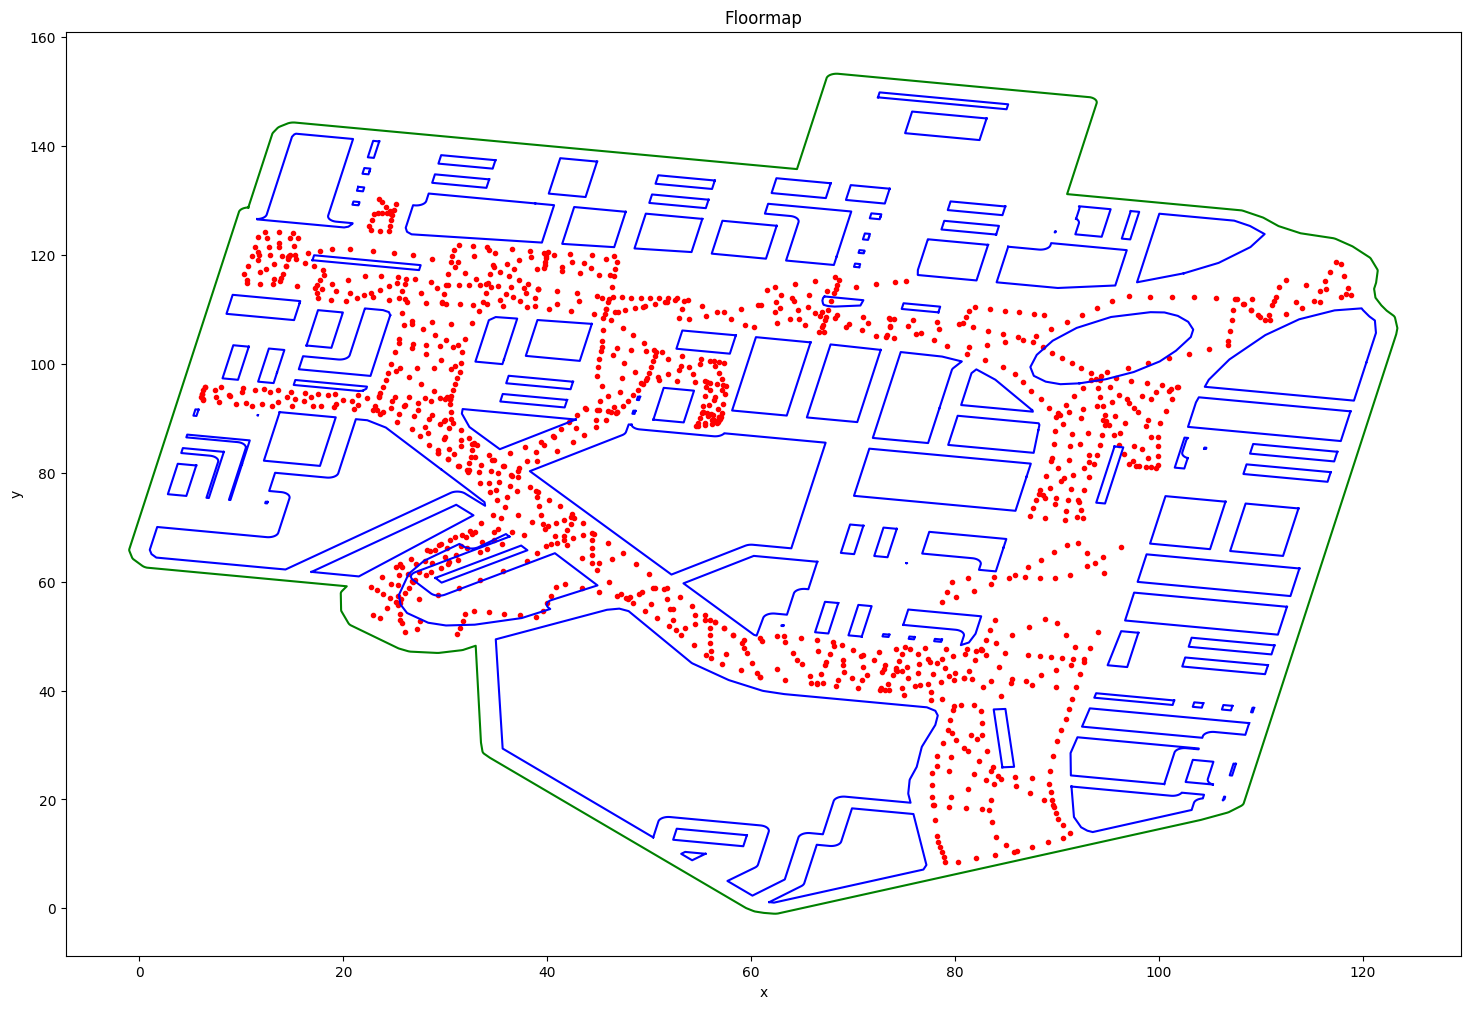

In [234]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.buffer(1.0).exterior.xy
  ax.plot(x, y, color="green", label="floor")

for store_polygon in store_polygons:
  if floor_polygons[0].buffer(1.0).contains(store_polygon.buffer(-1.0)):
    x, y = store_polygon.buffer(-1.0).exterior.xy
    ax.plot(x, y, color="blue", label="store")


ax.scatter(fingerprint_df["x"].values, fingerprint_df["y"].values, marker=".", color="red", label="fingerprint_loc")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

plt.ticklabel_format(useOffset=False)
plt.show()